<a href="https://colab.research.google.com/github/sk48880/LTFS-Data-Science-Finhack---Anlytics-Vidhya/blob/master/Loan_Default_Prediction_EDA_%26_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!pip install catboost

    100% |████████████████████████████████| 60.6MB 607kB/s 


In [0]:
!pip install vecstack

In [0]:
import re # regex
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import HTML, display, clear_output
import time


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE, RFECV,VarianceThreshold,chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler,Normalizer 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# Creating a Random Grid

from vecstack import stacking
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

import lightgbm as lgb
import xgboost as xgb
import catboost
from catboost import Pool, CatBoostClassifier,cv
from xgboost import XGBClassifier

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols,Logit

from datetime import datetime
import os
print(os.listdir("/content/"))

['.config', 'adc.json', 'train.csv', 'sample_submission.csv', 'test.csv', 'sample_data']


In [0]:
%%time
train = pd.read_csv("/content/train.csv",parse_dates=['Date.of.Birth','DisbursalDate'])
test = pd.read_csv("/content/test.csv",parse_dates=['Date.of.Birth','DisbursalDate'])
sub = pd.read_csv("/content/sample_submission.csv")

CPU times: user 1min 16s, sys: 112 ms, total: 1min 16s
Wall time: 1min 16s


In [0]:
train.shape, test.shape, sub.shape

((233154, 41), (112392, 40), (112392, 2))

In [0]:
print('Loan default rate in first EMI is:', format(train.loan_default.sum()/train.shape[0]))

Loan default rate in first EMI is: 0.2170711203753742


In [0]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,1977-09-12,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null datetime64[ns]
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null datetime64[ns]
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag   

In [0]:
df = train.copy()

In [0]:
df.loan_default.value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

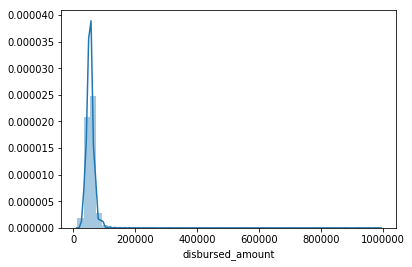

In [0]:
sns.distplot(df.disbursed_amount)

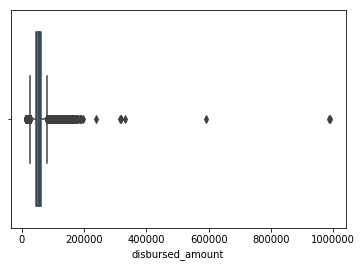

In [0]:
sns.boxplot(df.disbursed_amount)

In [0]:
## removed outliers
df=df[df['disbursed_amount']<200000].reset_index(drop=True)

In [0]:
df['Employment.Type'].unique()

array(['Salaried', 'Self employed', nan], dtype=object)

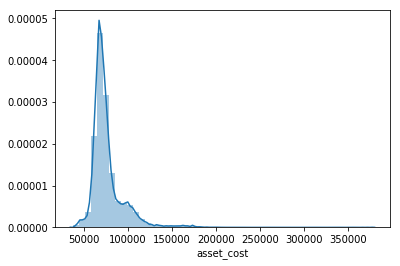

In [0]:
sns.distplot(df.asset_cost)

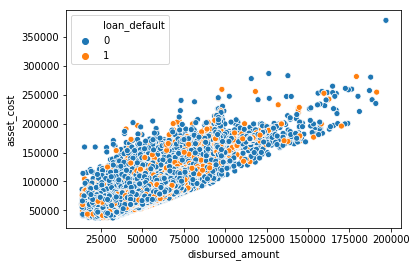

In [0]:
sns.scatterplot(y=df.asset_cost, x=df.disbursed_amount,hue=df.loan_default)

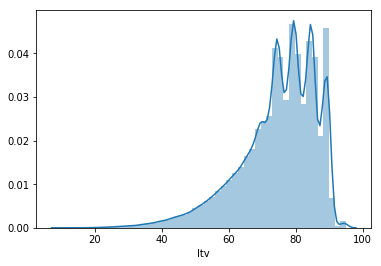

In [0]:
sns.distplot(df.ltv)

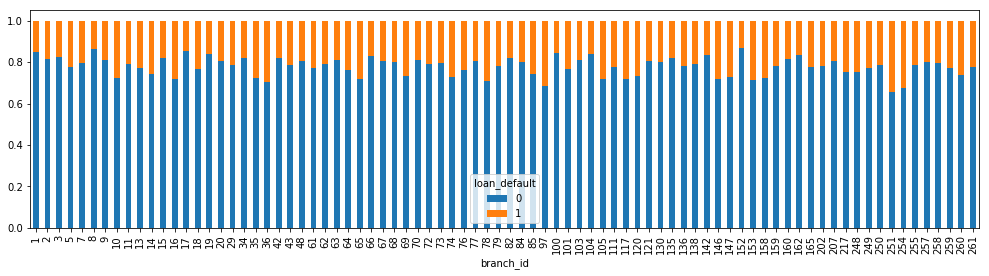

In [0]:
ct=pd.crosstab(df.branch_id, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))

In [0]:
df.supplier_id.nunique()

2952

In [0]:
df.manufacturer_id.nunique()

10

(463.02843043903846,
 4.6948116493874514e-94,
 9,
 array([[4.43337617e+04, 1.22922383e+04],
        [1.30826327e+04, 3.62736733e+03],
        [8.00068362e+03, 2.21831638e+03],
        [2.12986199e+04, 5.90538006e+03],
        [1.88292828e+03, 5.22071719e+02],
        [8.57566180e+04, 2.37773820e+04],
        [7.56146417e+03, 2.09653583e+03],
        [6.09113598e+02, 1.68886402e+02],
        [7.82922362e-01, 2.17077638e-01],
        [9.39506835e+00, 2.60493165e+00]]))

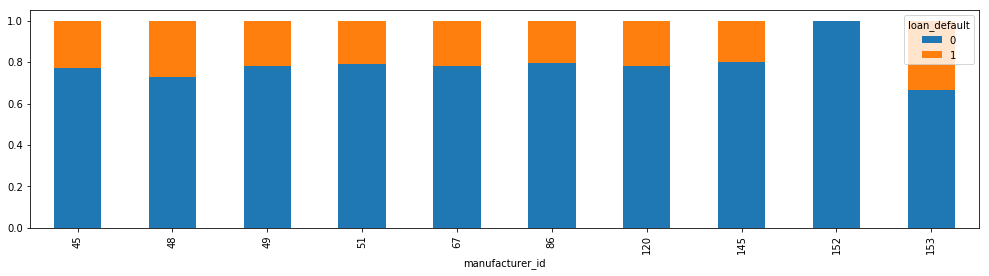

In [0]:
ct=pd.crosstab(df.manufacturer_id, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(402.9347894941585,
 1.2649508029241105e-89,
 1,
 array([[ 29148.19954792,   8081.80045208],
        [153387.80045208,  42529.19954792]]))

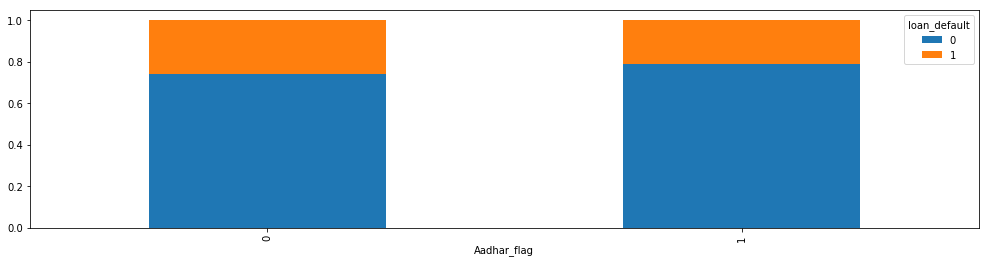

In [0]:
ct=pd.crosstab(df.Aadhar_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(1.00265262619473,
 0.31666950015785755,
 1,
 array([[168744.82258832,  46787.17741168],
        [ 13791.17741168,   3823.82258832]]))

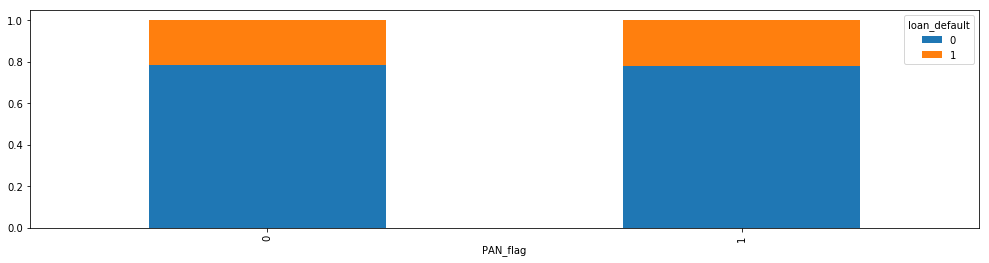

In [0]:
ct=pd.crosstab(df.PAN_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(445.7687139225628,
 6.011323264115359e-99,
 1,
 array([[156077.92168889,  43275.07831111],
        [ 26458.07831111,   7335.92168889]]))

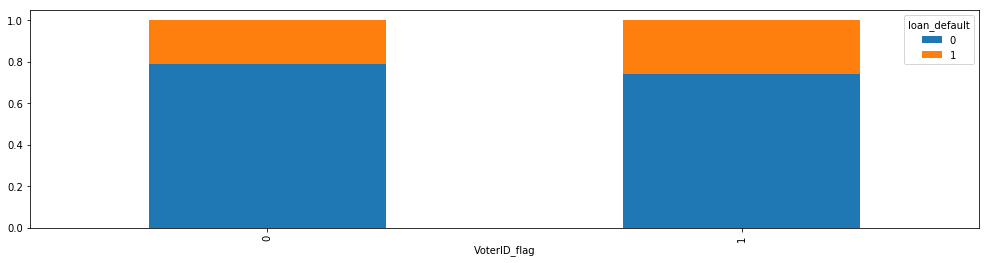

In [0]:
ct=pd.crosstab(df.VoterID_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(7.81450600180469,
 0.005182851325497511,
 1,
 array([[178293.34371877,  49434.65628123],
        [  4242.65628123,   1176.34371877]]))

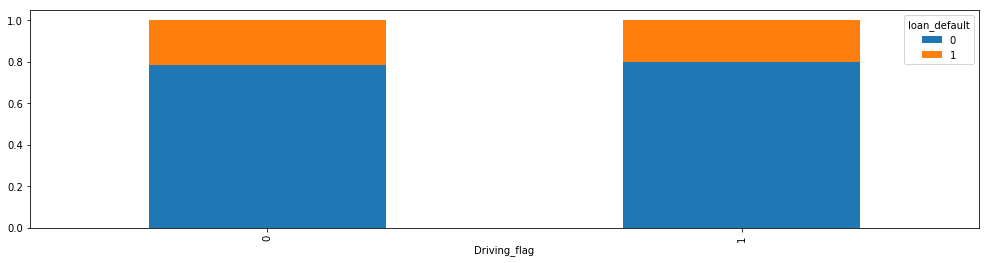

In [0]:
ct=pd.crosstab(df.Driving_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(13.080179391070391,
 0.00029843687220371747,
 1,
 array([[1.82147671e+05, 5.05033295e+04],
        [3.88329492e+02, 1.07670508e+02]]))

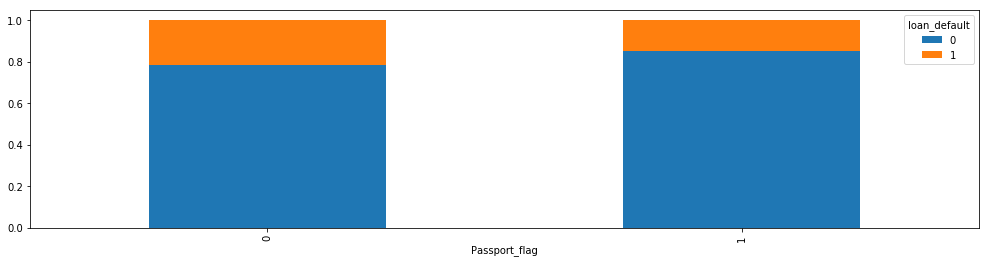

In [0]:
ct=pd.crosstab(df.Passport_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

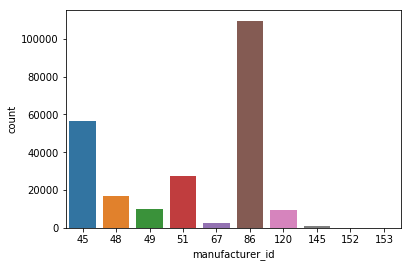

In [0]:
sns.countplot(x=df.manufacturer_id)

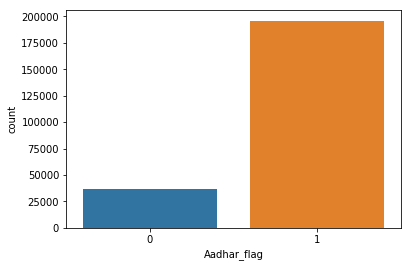

In [0]:
sns.countplot(x=df.Aadhar_flag)

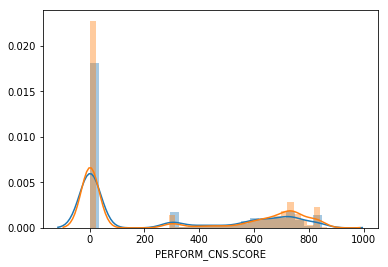

In [0]:
sns.distplot(df[df['loan_default']==1]['PERFORM_CNS.SCORE'])
sns.distplot(df[df['loan_default']==0]['PERFORM_CNS.SCORE'])

In [0]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116949
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9199
M-Very High Risk                                             8776
F-Low Risk                                                   8484
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3987
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3747
Not Scored: Not Enough Info available on the customer        3672
Not Scored

(2191.893143590023, 0.0, 19, array([[1.10579954e+04, 3.06600456e+03],
        [7.20210281e+03, 1.99689719e+03],
        [1.25619893e+04, 3.48301070e+03],
        [8.89243219e+03, 2.46556781e+03],
        [4.55739107e+03, 1.26360893e+03],
        [6.64231332e+03, 1.84168668e+03],
        [3.12151146e+03, 8.65488542e+02],
        [5.36693279e+03, 1.48806721e+03],
        [4.35069957e+03, 1.20630043e+03],
        [2.93361009e+03, 8.13389909e+02],
        [6.48024839e+03, 1.79675161e+03],
        [8.87833959e+02, 2.46166041e+02],
        [6.87092665e+03, 1.90507335e+03],
        [9.15619873e+04, 2.53870127e+04],
        [2.34876709e+00, 6.51232913e-01],
        [2.25794809e+03, 6.26051907e+02],
        [1.20100290e+03, 3.32997096e+02],
        [2.87489091e+03, 7.97109086e+02],
        [7.64132226e+02, 2.11867774e+02],
        [2.94770269e+03, 8.17297306e+02]]))

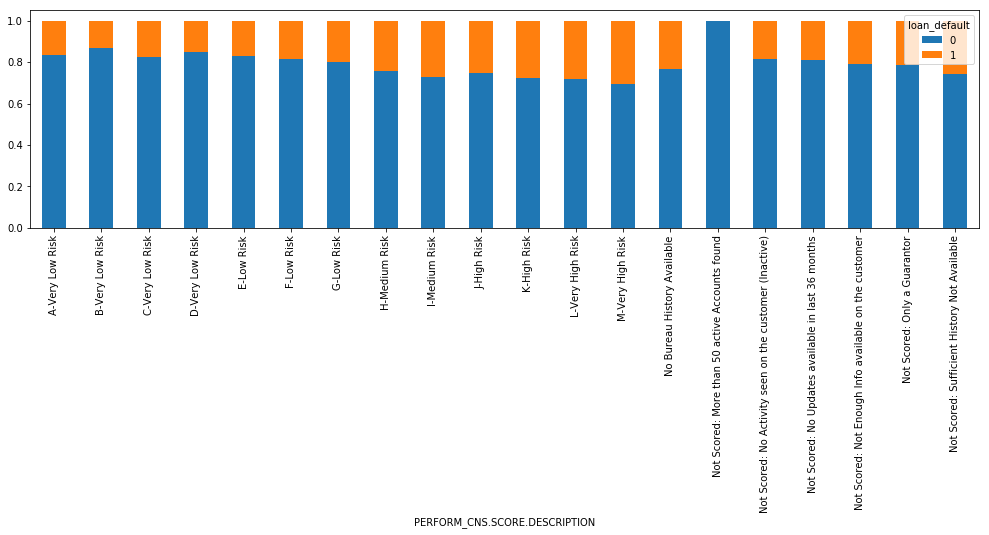

In [0]:
ct=pd.crosstab(df['PERFORM_CNS.SCORE.DESCRIPTION'], df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

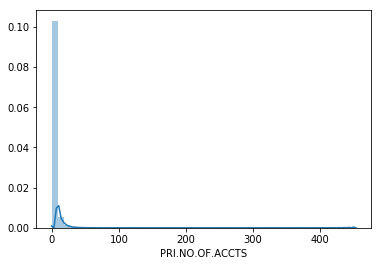

In [0]:
sns.distplot(df['PRI.NO.OF.ACCTS'])

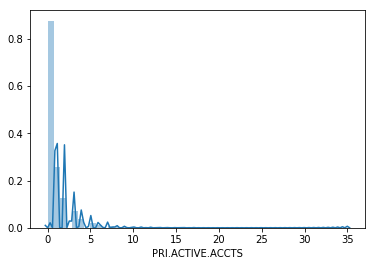

In [0]:
sns.distplot(df[df['loan_default']==1]['PRI.ACTIVE.ACCTS'])
# sns.distplot(df[df['loan_default']==0]['PRI.ACTIVE.ACCTS'])

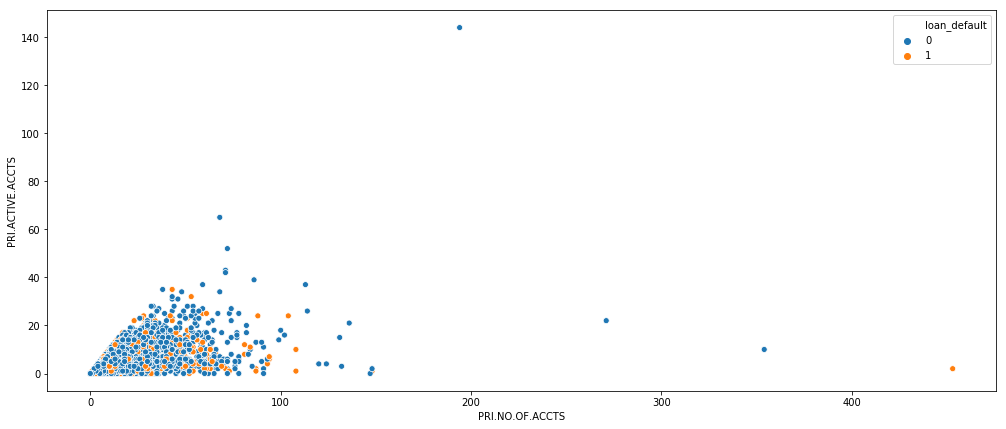

In [0]:
plt.subplots(figsize=(17,7))
sns.scatterplot(x=df['PRI.NO.OF.ACCTS'] , y = df['PRI.ACTIVE.ACCTS'],hue=df.loan_default)

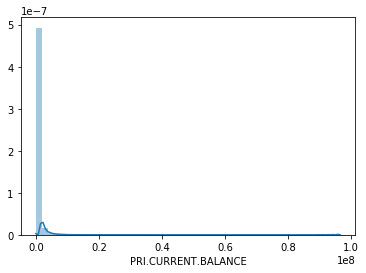

In [0]:
sns.distplot(df[df['PRI.CURRENT.BALANCE']>0]['PRI.CURRENT.BALANCE'])

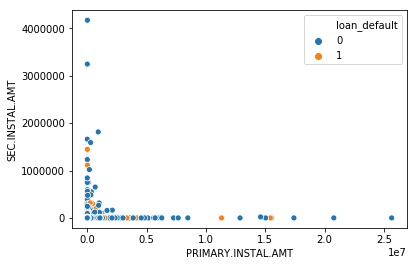

In [0]:
sns.scatterplot(x=df['PRIMARY.INSTAL.AMT'],  y=df['SEC.INSTAL.AMT'],hue=df['loan_default'])

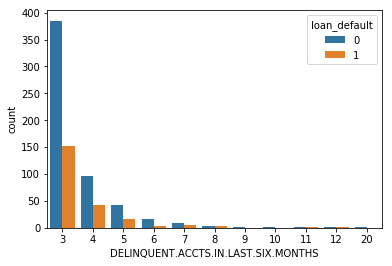

In [0]:
sns.countplot(df[df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>2]['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'],hue=df.loan_default)

In [0]:
train.drop(index = [48879,85588,134575], axis=0, inplace= True)
train.reset_index(inplace= True)
train.drop('index', axis= 1, inplace = True)

In [0]:
train=train[train['disbursed_amount']<200000].reset_index(drop=True)

In [0]:
## There is missing value in only one column which is employment type we will impute this information
train['Employment.Type'].fillna('Others',inplace = True)
test['Employment.Type'].fillna('Others',inplace = True)

In [0]:
train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [0]:
train.drop(columns= ['UniqueID','PAN_flag','MobileNo_Avl_Flag'], axis=1, inplace= True)
test.drop(columns= ['UniqueID','PAN_flag','MobileNo_Avl_Flag'], axis=1, inplace =True)

In [0]:
train['BirthYear'] = train['Date.of.Birth'].dt.year
test['BirthYear'] = test['Date.of.Birth'].dt.year

train['DisbursalYear'] = train['DisbursalDate'].dt.year
test['DisbursalYear'] = test['DisbursalDate'].dt.year

train['Offset'] = 0
test['Offset'] = 0

train.loc[train.BirthYear > 2018, 'Offset'] = 100
test.loc[test.BirthYear > 2018, 'Offset'] = 100

train['BirthYear'] = train['BirthYear'] - train['Offset']
test['BirthYear'] = test['BirthYear'] - test['Offset']

train['ClientAge'] = train['DisbursalYear'] - train['BirthYear']
test['ClientAge'] = test['DisbursalYear'] - test['BirthYear']

train.drop(['Date.of.Birth','DisbursalYear','DisbursalDate','Offset'], axis=1, inplace= True)
test.drop(['Date.of.Birth','DisbursalYear','DisbursalDate','Offset'], axis=1, inplace= True)


In [0]:
train['avg_acct_age_mnth'] = ((train['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + train['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
train['avg_credit_hist_mnth'] = ((train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

test['avg_acct_age_mnth'] = ((test['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + test['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
test['avg_credit_hist_mnth'] = ((test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

In [0]:
train.drop(columns= ['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace= True)
test.drop(columns= ['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace =True)

In [0]:
lb = LabelEncoder()
train['Employment.Type'] = lb.fit_transform(train['Employment.Type'])
test['Employment.Type'] = lb.transform(test['Employment.Type'])


train['PERFORM_CNS.SCORE.DESCRIPTION'] = lb.fit_transform(train['PERFORM_CNS.SCORE.DESCRIPTION'])
test['PERFORM_CNS.SCORE.DESCRIPTION'] = lb.transform(test['PERFORM_CNS.SCORE.DESCRIPTION'])

In [0]:
models = [
    GradientBoostingClassifier(random_state=0, learning_rate=0.01, 
                  n_estimators=100, max_depth=5),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=5),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, 
                  n_estimators=100, max_depth=5)
]

In [0]:
S_train, S_test = stacking(models,                   
                           train.drop('loan_default',1), train.loan_default, test,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=True,
                           save_dir=None, 
                           metric='roc_auc', 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=42) 
#                            verbose=2)

In [0]:
# x_tr = pd.DataFrame({'gbm':S_train[:,1]})
# x_tr['rf'] =S_train[:,3]
# x_tr['xgb'] =S_train[:,5]
# x_tr.head()

In [0]:
# train.drop(columns= ['gbm','rf','xgb'], axis=1, inplace= True)
# test.drop(columns= ['gbm','rf','xgb'], axis=1, inplace =True)

In [0]:
train['gbm'] = S_train[:,1]
train['rf'] = S_train[:,3]
train['xgb'] = S_train[:,5]

test['gbm'] = S_test[:,1]
test['rf'] = S_test[:,3]
test['xgb'] = S_test[:,5]

In [0]:
x_train,x_test,y_train,y_test = train_test_split(train.drop('loan_default',1), train.loan_default, test_size = 0.2,
                                                random_state = 300)

In [0]:
categ_column = ['branch_id','supplier_id', 'manufacturer_id','Current_pincode_ID','State_ID', 
                'Employee_code_ID','Aadhar_flag','VoterID_flag','Driving_flag', 'Passport_flag',
                'Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','avg_acct_age_mnth','avg_credit_hist_mnth']


In [0]:
_train = Pool(x_train, label=y_train,cat_features= categ_column)
_valid = Pool(x_test, label=y_test,cat_features= categ_column)

In [0]:
# _train = Pool(x_train, label=y_train)
# _valid = Pool(x_test, label=y_test)

In [0]:
model = CatBoostClassifier(subsample=0.9, 
                           custom_loss='Logloss',
                           l2_leaf_reg = 10,
                           random_strength = 0,
                           max_depth=7,
                           eval_metric="AUC",
                           learning_rate=0.01,
                           iterations=10000,
                           bootstrap_type='Bernoulli',
                           task_type="GPU",
                           random_seed=42,
                           od_type="Iter",
                           border_count=128
                          )

In [0]:
fit_model = model.fit(_train,verbose_eval=1000, early_stopping_rounds=1000,
                      eval_set=[_valid],use_best_model=True,plot=False)

0:	learn: 0.6452306	test: 0.6467279	best: 0.6467279 (0)	total: 81.5ms	remaining: 13m 34s
1000:	learn: 0.6842019	test: 0.6722206	best: 0.6722206 (1000)	total: 50.6s	remaining: 7m 34s
2000:	learn: 0.6975827	test: 0.6743500	best: 0.6743500 (2000)	total: 1m 38s	remaining: 6m 33s
3000:	learn: 0.7082159	test: 0.6752672	best: 0.6752672 (3000)	total: 2m 27s	remaining: 5m 43s
4000:	learn: 0.7182191	test: 0.6755713	best: 0.6755751 (3990)	total: 3m 15s	remaining: 4m 52s
5000:	learn: 0.7274729	test: 0.6757280	best: 0.6757733 (4772)	total: 4m 7s	remaining: 4m 7s
6000:	learn: 0.7365879	test: 0.6759208	best: 0.6759320 (5988)	total: 4m 58s	remaining: 3m 18s
7000:	learn: 0.7451425	test: 0.6759525	best: 0.6759770 (6728)	total: 5m 47s	remaining: 2m 28s
8000:	learn: 0.7536075	test: 0.6759636	best: 0.6759997 (7712)	total: 6m 35s	remaining: 1m 38s
bestTest = 0.6759997308
bestIteration = 7712
Shrink model to first 7713 iterations.


In [0]:
prediction = fit_model.predict_proba(test)[:,1]

In [0]:
subm = pd.read_csv('/content/sample_submission.csv')
subm["loan_default"] = prediction
subm.to_csv("submission.csv", index=False)
subm.head()

,UniqueID,loan_default
0,655269,0.291008
1,723482,0.352809
2,758529,0.319160
3,763449,0.224903
4,708663,0.280575


In [0]:
# fimp = pd.DataFrame.from_dict({'Columns':fit_model.feature_names_,'Value':fit_model.feature_importances_})
# fimp = fimp.sort_values(by = 'Value', ascending = False)
# fimp

### K Fold Cross Validation

In [0]:
#  def run_cat(model,  trt, tst, tar,n_splits=5, plot=False):   
#     kf = KFold(n_splits=n_splits, random_state=432013, shuffle=True)
#     oof = np.zeros(len(trt))
#     feature_importance_df = pd.DataFrame()
#     y_valid_pred = 0 * tar
#     y_test_pred = 0
#     for n_fold, (train_index, valid_index) in enumerate(kf.split(trt, tar)):
#         y_train, y_valid = tar.iloc[train_index], tar.iloc[valid_index]
#         X_train, X_valid = trt.iloc[train_index,:], trt.iloc[valid_index,:]
#         _train = Pool(X_train, label=y_train,cat_features= categ_column)
#         _valid = Pool(X_valid, label=y_valid,cat_features= categ_column)
#         print( "Fold ", n_fold)
#         fit_model = model.fit(_train,
#                               verbose_eval=1000, 
#                               early_stopping_rounds=1000,
#                               eval_set=[_valid],
#                               use_best_model=True,
#                               plot=False,
                                            
#                              )
#         pred = fit_model.predict_proba(X_valid)[:,1]
#         oof[valid_index] = pred
#         print( "auc = ", roc_auc_score(y_valid, pred) )
#         y_valid_pred.iloc[valid_index] = pred
#         y_test_pred += fit_model.predict_proba(tst)[:,1]
#     y_test_pred /= n_splits
#     print("average auc:", roc_auc_score(tar, oof))
#     return y_test_pred, oof

In [0]:
# cat_train = train.drop('loan_default',axis =1)
# cat_target = train.loan_default
# cat_test = test.copy()

In [0]:
# y_test_pred, oof = run_cat(model,cat_train, cat_test, cat_target)

In [0]:
# sub_df = pd.read_csv('/content/sample_submission.csv')
# sub_df["loan_default"] = y_test_pred
# sub_df.to_csv("submission_kfold.csv", index=False)
# sub_df.head()